In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rc("axes", titlesize=18)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=13)
plt.rc("ytick", labelsize=13)
plt.rc("legend", fontsize=13)
plt.rc("font", size=13)

In [2]:
df = pd.read_csv("masterspreadsheet.csv")
df.head()

,Unnamed: 0,ModelType,agents,discount_rate,epsilon,epsilon_decay,hidden_size,learning_rate,lookback,n1,...,num_layers,tn_mean_score,tn_mean_time,tn_rank,tr_cooperation_percentage,tr_cumul_regret,tr_cumul_reward,tr_defection_percentage,tr_final_loss,tr_mean_reward
0,0,RNN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.99,0.1,0.0,4.0,0.01,1,NaN,...,1.0,615.801613,27.080110,25,0.326579,360387,479613,0.673421,3.586149,1.712904
1,1,RNN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.99,0.1,0.0,32.0,0.01,1,NaN,...,1.0,492.674194,32.302460,26,0.266554,379237,460763,0.733446,2.267997,1.645582
2,2,RNN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.99,0.1,0.0,64.0,0.01,1,NaN,...,1.0,488.369355,31.665495,26,0.384579,350600,489400,0.615421,2.660373,1.747857
3,3,RNN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.99,0.1,0.0,4.0,0.01,2,NaN,...,1.0,516.111290,30.256132,25,0.258746,332749,507251,0.741254,3.584488,1.811611
4,4,RNN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.99,0.1,0.0,32.0,0.01,2,NaN,...,1.0,482.979032,36.665985,26,0.409950,336942,503058,0.590050,2.484999,1.796636


In [3]:
df = df.drop("Unnamed: 0", axis=1)

In [4]:
def plot_histogram(x: pd.DataFrame,bins: int, x_label: str, y_label: str, title: str) -> None:
    plt.figure(figsize=(15,8))
    ax = plt.gca()
    x.hist(ax=ax, bins=bins, density=True, color="xkcd:azure")
    x.plot.kde(ax=ax, color="xkcd:tangerine")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.xlim([x.min(), x.max()])

Firstly, I will compare DQN and RNN agents to see whether the choice of neural network affects model performance.

In [5]:
count_rnn = len(df[df["ModelType"] == "RNN"])
count_dqn = len(df[df["ModelType"] == "DQN"])
cumulative_rank_rnn = df[df["ModelType"] == "RNN"]["tn_rank"].sum()
cumulative_rank_dqn = df[df["ModelType"] == "DQN"]["tn_rank"].sum()
avg_rank_rnn = cumulative_rank_rnn / count_rnn
avg_rank_dqn = cumulative_rank_dqn / count_dqn

print(f"Average rank of RNN agents is {avg_rank_rnn}")
print(f"Average rank of DQN agents is {avg_rank_dqn}")

Average rank of RNN agents is 25.4
Average rank of DQN agents is 23.770206022187004


It looks as though DQN agents fared better than RNN agents in tournaments. It is important to note that there were only 18 RNN grid searches, meaning that our comparison would be more reliable if we had more runs of RNN.

<h2>Analysis of DQN agents.</h2>

Since there are a lot more DQN grid searches than RNN, the insights gained from analysing DQN will be more reliable. I will investigate various hyperparameters such as the exploration rate (epsilon), lookback, discount factor, learning rate, and number of layers.

In [6]:
dqn_agents = df[df["ModelType"] == "DQN"]

<h2>Discount Factor</h2>

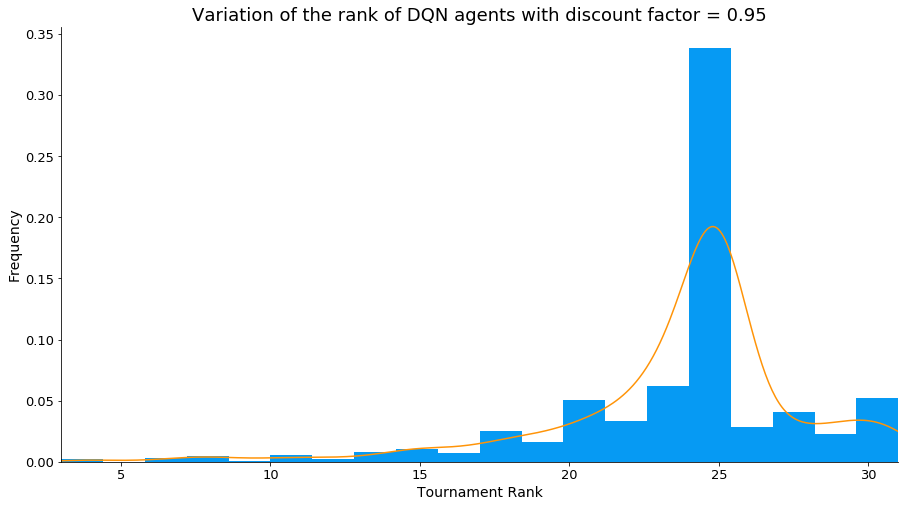

In [7]:
plot_histogram(dqn_agents[dqn_agents["discount_rate"] == 0.95]["tn_rank"], 20, "Tournament Rank", "Frequency", "Variation of the rank of DQN agents with discount factor = 0.95")

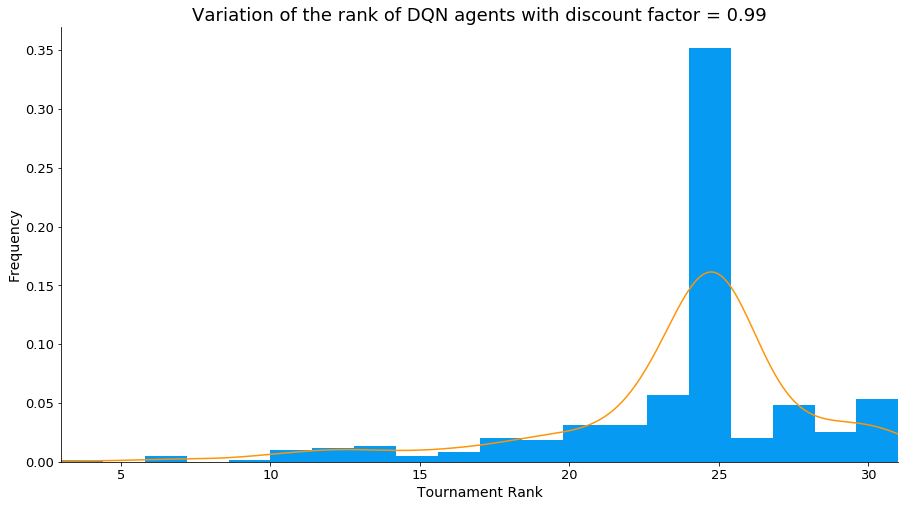

In [8]:
plot_histogram(dqn_agents[dqn_agents["discount_rate"] == 0.99]["tn_rank"], 20, "Tournament Rank",  "Frequency", "Variation of the rank of DQN agents with discount factor = 0.99")

In [9]:
num_95 = len(dqn_agents[dqn_agents["discount_rate"] == 0.95])
num_99 = len(dqn_agents[dqn_agents["discount_rate"] == 0.99])
print(f"Num of DQN agents w/ discount rate = 0.95: {num_95}")
print(f"Num of DQN agents w/ discount rate = 0.99: {num_99}")

Num of DQN agents w/ discount rate = 0.95: 1465
Num of DQN agents w/ discount rate = 0.99: 428


In [10]:
avg_rank_95 = dqn_agents[dqn_agents["discount_rate"] == 0.95]["tn_rank"].sum() / num_95
avg_rank_99 = dqn_agents[dqn_agents["discount_rate"] == 0.99]["tn_rank"].sum() / num_99

print(f"Average rank of DQN agents w/ discount rate 0.95: {avg_rank_95}")
print(f"Average rank of DQN agents w/ discount rate 0.99: {avg_rank_99}")

Average rank of DQN agents w/ discount rate 0.95: 23.780204778156996
Average rank of DQN agents w/ discount rate 0.99: 23.735981308411215


It looks like discount factor does not play a huge role affecting the performance of DQN agents. This is surprising as one interpretation of the discount factor is how much an agent values future rewards. Increasing the discount factor would lead to agents valuing potential future rewards more highly and adopting a sustainable long-term strategy based around cooperation rather than defection. 

<h2>Exploration Rate</h2>

In [11]:
dqn_agents["epsilon"].value_counts()

0.20    760
0.10    614
0.05    507
0.15     12
Name: epsilon, dtype: int64

In [12]:
num_20 = dqn_agents[dqn_agents["epsilon"] == 0.2]
num_10 = dqn_agents[dqn_agents["epsilon"] == 0.1]
num_05 = dqn_agents[dqn_agents["epsilon"] == 0.05]
num_15 = dqn_agents[dqn_agents["epsilon"] == 0.15]

avg_rank_20 = dqn_agents[dqn_agents["epsilon"] == 0.2]["tn_rank"].sum() / len(num_20)
avg_rank_10 = dqn_agents[dqn_agents["epsilon"] == 0.1]["tn_rank"].sum() / len(num_10)
avg_rank_05 = dqn_agents[dqn_agents["epsilon"] == 0.05]["tn_rank"].sum() / len(num_05)
avg_rank_15 = dqn_agents[dqn_agents["epsilon"] == 0.15]["tn_rank"].sum() / len(num_15)

print(f"Avg rank of DQN w/ epsilon = 0.2:\t{avg_rank_20}")
print(f"Avg rank of DQN w/ epsilon = 0.15:\t{avg_rank_15}")
print(f"Avg rank of DQN w/ epsilon = 0.1:\t{avg_rank_10}")
print(f"Avg rank of DQN w/ epsilon = 0.05:\t{avg_rank_05}")

Avg rank of DQN w/ epsilon = 0.2:	23.58815789473684
Avg rank of DQN w/ epsilon = 0.15:	26.333333333333332
Avg rank of DQN w/ epsilon = 0.1:	23.8257328990228
Avg rank of DQN w/ epsilon = 0.05:	23.91518737672584


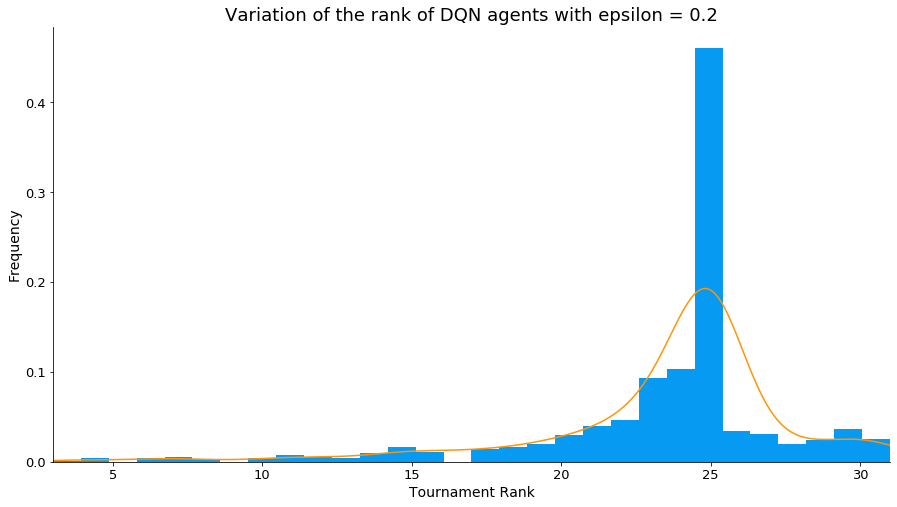

In [13]:
plot_histogram(num_20["tn_rank"], 30, "Tournament Rank", "Frequency", "Variation of the rank of DQN agents with epsilon = 0.2")

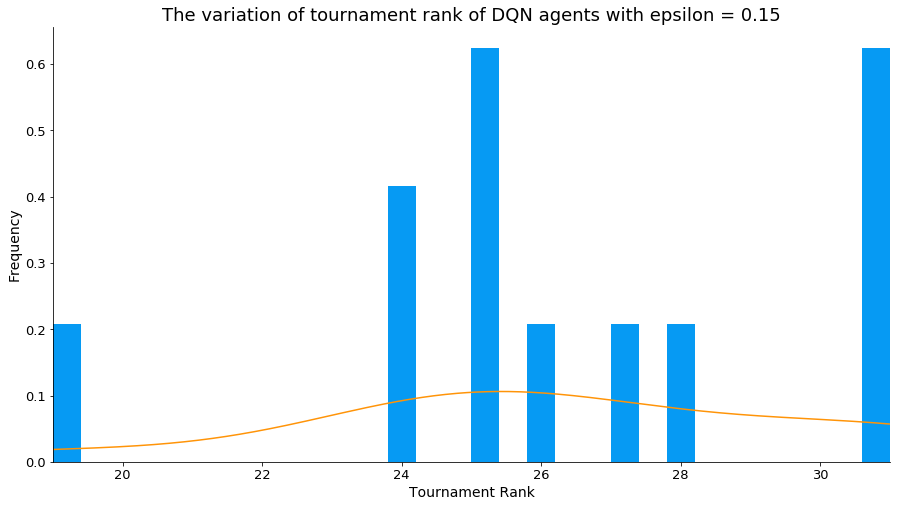

In [14]:
plot_histogram(num_15["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with epsilon = 0.15")

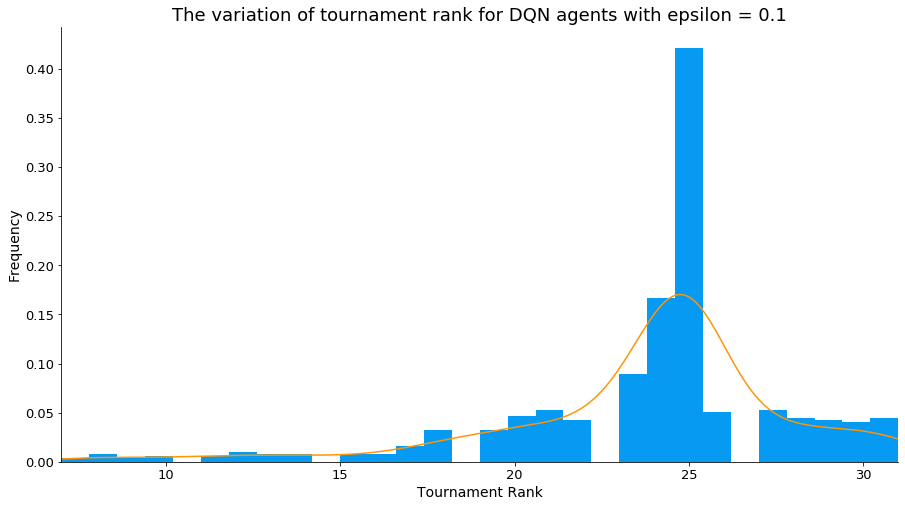

In [15]:
plot_histogram(num_10["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank for DQN agents with epsilon = 0.1")

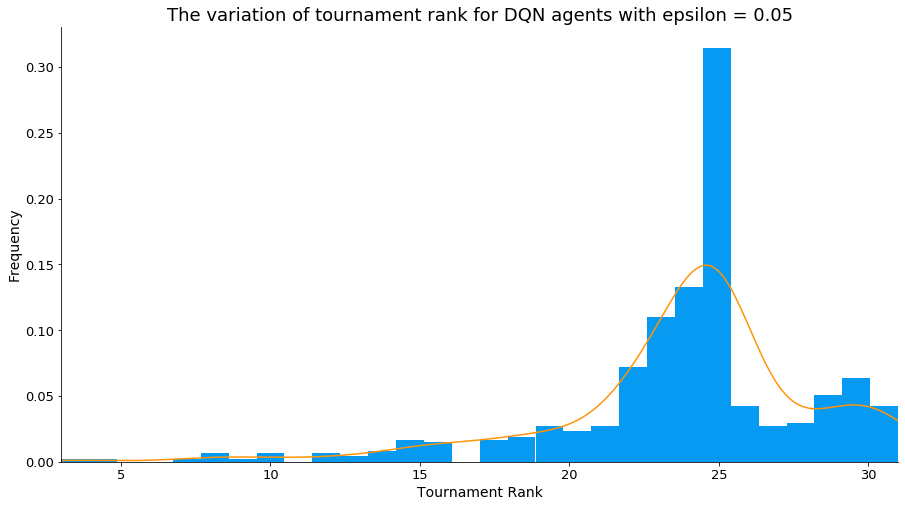

In [16]:
plot_histogram(num_05["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank for DQN agents with epsilon = 0.05")

Similarly to discount rate, it does not seem as though epsilon has a major impact on the performance of the model.

<h2>Lookback</h2>

In [30]:
lb_counts = dqn_agents["lookback"].value_counts()
print(lb_counts)

8     501
4     473
10    283
2     277
6     198
1     161
Name: lookback, dtype: int64


In [18]:
avg_rnk_8lb = dqn_agents[dqn_agents["lookback"] == 8]["tn_rank"].sum() / lb_counts[8]
avg_rnk_4lb = dqn_agents[dqn_agents["lookback"] == 4]["tn_rank"].sum() / lb_counts[4]
avg_rnk_10lb = dqn_agents[dqn_agents["lookback"] == 10]["tn_rank"].sum() / lb_counts[10]
avg_rnk_2lb = dqn_agents[dqn_agents["lookback"] == 2]["tn_rank"].sum() / lb_counts[2]
avg_rnk_6lb = dqn_agents[dqn_agents["lookback"] == 6]["tn_rank"].sum() / lb_counts[6]
avg_rnk_1lb = dqn_agents[dqn_agents["lookback"] == 1]["tn_rank"].sum() / lb_counts[1]

print(f"Average rank of DQN agents with a lookback of 1:\t{avg_rnk_1lb}")
print(f"Average rank of DQN agents with a lookback of 2:\t{avg_rnk_2lb}")
print(f"Average rank of DQN agents with a lookback of 4:\t{avg_rnk_4lb}")
print(f"Average rank of DQN agents with a lookback of 6:\t{avg_rnk_6lb}")
print(f"Average rank of DQN agents with a lookback of 8:\t{avg_rnk_8lb}")
print(f"Average rank of DQN agents with a lookback of 10:\t{avg_rnk_10lb}")

Average rank of DQN agents with a lookback of 1:	24.304347826086957
Average rank of DQN agents with a lookback of 2:	23.379061371841154
Average rank of DQN agents with a lookback of 4:	23.676532769556026
Average rank of DQN agents with a lookback of 6:	23.893939393939394
Average rank of DQN agents with a lookback of 8:	23.982035928143713
Average rank of DQN agents with a lookback of 10:	23.54416961130742


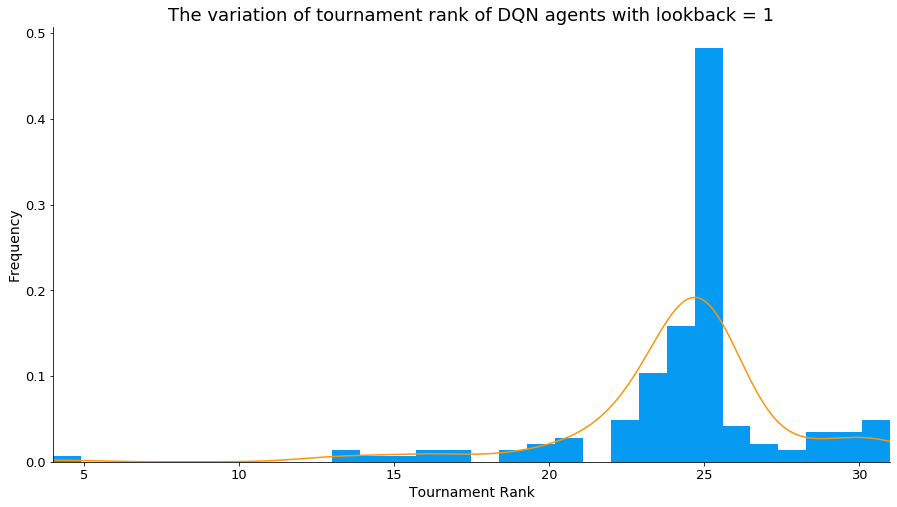

In [23]:
plot_histogram(dqn_agents[dqn_agents["lookback"] == 1]["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with lookback = 1")

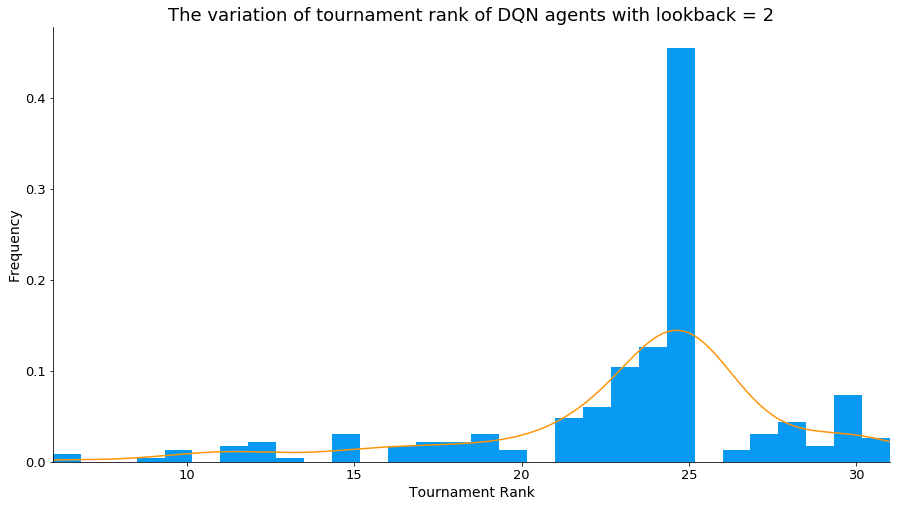

In [24]:
plot_histogram(dqn_agents[dqn_agents["lookback"] == 2]["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with lookback = 2")

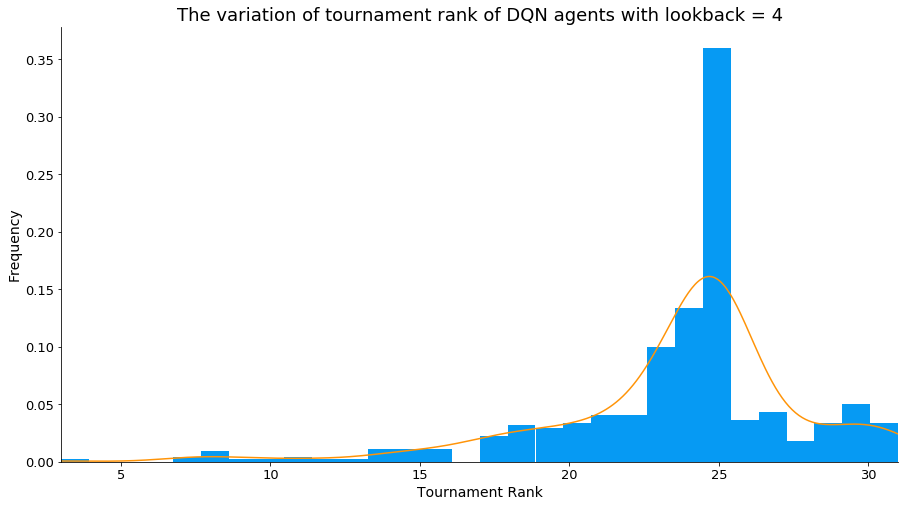

In [26]:
plot_histogram(dqn_agents[dqn_agents["lookback"] == 4]["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with lookback = 4")

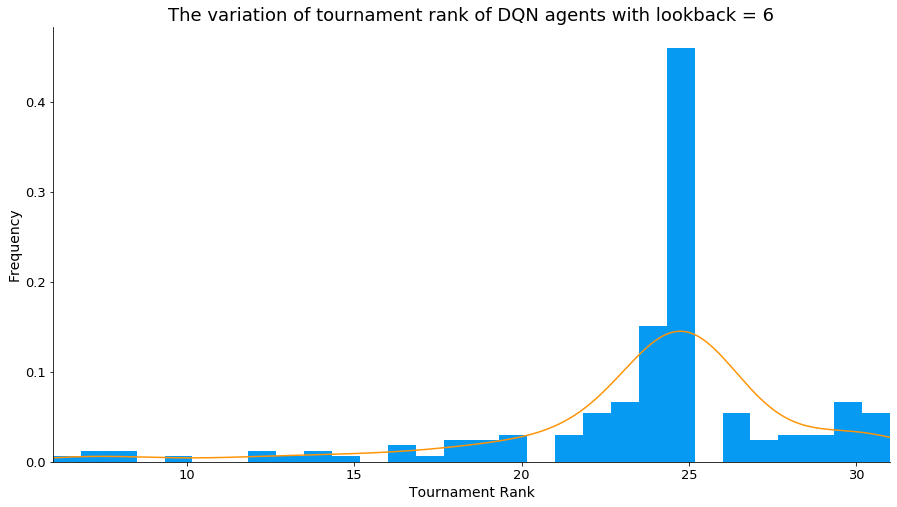

In [27]:
plot_histogram(dqn_agents[dqn_agents["lookback"] == 6]["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with lookback = 6")

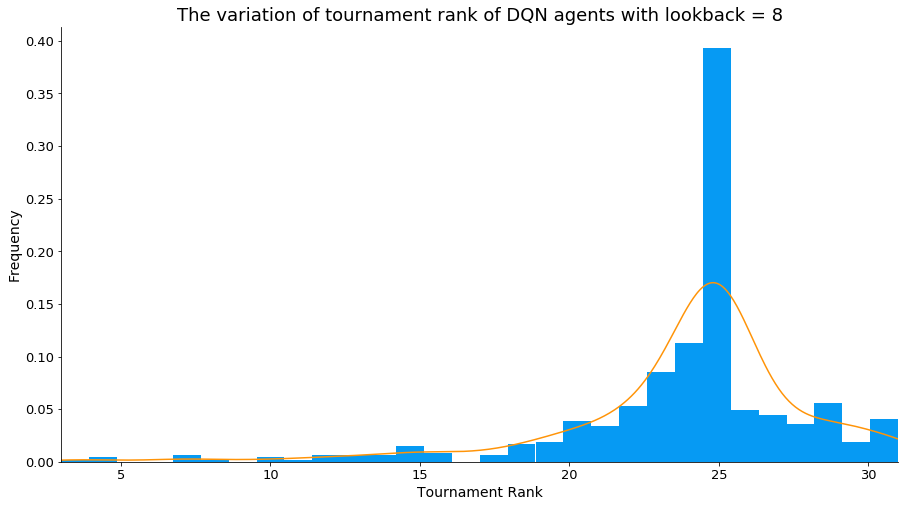

In [28]:
plot_histogram(dqn_agents[dqn_agents["lookback"] == 8]["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with lookback = 8")

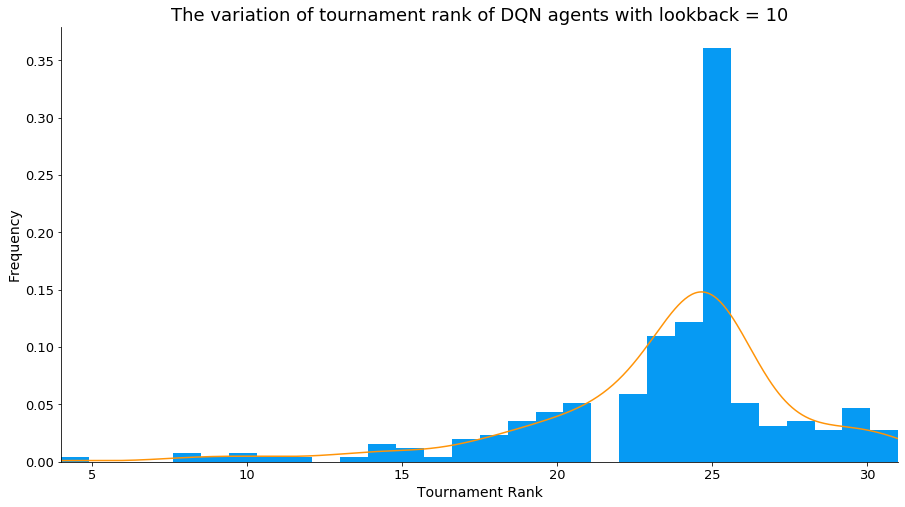

In [29]:
plot_histogram(dqn_agents[dqn_agents["lookback"] == 10]["tn_rank"], 30, "Tournament Rank", "Frequency", "The variation of tournament rank of DQN agents with lookback = 10")

As expected, a lookback of 1 performs the worst due to the space of available strategies being constrained. Surprisingly, a lookback of 2 has a higher average rank than 4, 6, and 8. Upon observing the graphs, we notice that a lookback of 6 achieves the highest amount of results in the top 10. 

In general, it seems as though increasing the lookback past a certain threshold does not aid the agent perform better in the tournament, possibly due to the difficulty of learning such complicated strategies. 


<h2>Analysing the top performing agents</h2>

In [35]:
top_10 = df[df["tn_rank"] <= 10]

In [37]:
top_10.head()

,ModelType,agents,discount_rate,epsilon,epsilon_decay,hidden_size,learning_rate,lookback,n1,n2,num_layers,tn_mean_score,tn_mean_time,tn_rank,tr_cooperation_percentage,tr_cumul_regret,tr_cumul_reward,tr_defection_percentage,tr_final_loss,tr_mean_reward
64,DQN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.99,0.05,0.0,NaN,0.010,4,4.0,NaN,NaN,801.001613,19.442528,3,0.971496,122750,717250,0.028504,2.139334,2.561607
69,DQN,"TitForTat,Nydegger,Downing,TidemanAndChieruzzi...",0.95,0.05,0.0,NaN,0.010,4,64.0,NaN,NaN,770.182258,33.282142,9,0.975007,122292,717708,0.024993,2.141736,2.563243
261,DQN,"TitForTat,TidemanAndChieruzzi,Nydegger,Grofman...",0.95,0.20,0.0,NaN,0.010,8,4.0,16.0,NaN,815.932258,18.509990,3,0.900340,62251,537749,0.099660,2.263090,2.688745
380,DQN,"TitForTat,TidemanAndChieruzzi,Nydegger,Grofman...",0.95,0.10,0.0,NaN,0.001,8,32.0,16.0,NaN,784.204839,17.684688,7,0.429325,76261,523739,0.570675,0.849232,2.618695
515,DQN,"TitForTat,OmegaTFT,TFTT,TTFT,GradualTFT,Genero...",0.95,0.10,0.0,NaN,0.001,4,32.0,NaN,NaN,783.727419,10.107510,8,0.794021,106951,613049,0.205979,0.255984,2.554371


In [39]:
top_10["epsilon"].value_counts()

0.20    16
0.10    11
0.05    10
Name: epsilon, dtype: int64

Epsilon = 0.15 does not appear here; however, 0.2 does so it is possible it did not appear due to the stochastic nature of our tournament.

In [40]:
top_10["lookback"].value_counts()

4     9
8     9
6     6
10    6
2     6
1     1
Name: lookback, dtype: int64

Lookback definitely affects performance especially if it is too low. The ideal range is probably between 4-10 depending on how much time you have to train your models.

In [63]:
agent_counts = {}

for idx, r in top_10.iterrows():
    for agent in r["agents"].split(","):
        if agent in agent_counts:
            agent_counts[agent] += 1
        else:
            agent_counts[agent] = 1
sorted_agent_counts = {k : v for k, v in sorted(agent_counts.items(), key=lambda x: x[1])}
for agent in sorted_agent_counts.keys():
    print(f"{agent} {sorted_agent_counts[agent]}")

AllC 1
AllD 1
SteinAndRapoport 1
SecondByWeiner 1
Downing 2
Champion 2
SecondByGraaskampKatzen 2
Borufsen 3
TFTT 7
GradualTFT 7
GenerousTFT 7
TTFT 8
OmegaTFT 10
Grofman 19
Shubik 19
Nydegger 21
TidemanAndChieruzzi 21
TitForTat 36


It looks like TFT appears very often in the top performing agents but we need to be careful in case everyone used TFT when training. Lets check to see how frequently each of those agents appear in the rest of the grid searches

In [65]:
sorted_agent_counts["TitForTat"]

36

In [88]:
all_agent_counts = {}
for idx, r in df.iterrows():
    for agent in r["agents"].split(","):
        if agent in all_agent_counts:
            all_agent_counts[agent] += 1
        else:
            all_agent_counts[agent] = 1
print("TFT: {}".format(sorted_agent_counts["TitForTat"] * 100 / all_agent_counts["TitForTat"]))
print("TidemanAndChieruzzi: {}".format(sorted_agent_counts["TidemanAndChieruzzi"] * 100/ all_agent_counts["TidemanAndChieruzzi"]))
print("Nydegger: {}".format(sorted_agent_counts["Nydegger"] * 100 / all_agent_counts["Nydegger"]))
print("Shubik: {}".format(sorted_agent_counts["Shubik"] * 100 / all_agent_counts["Shubik"]))
print("Grofman: {}".format(sorted_agent_counts["Grofman"] * 100 / all_agent_counts["Grofman"]))
print("OmegaTFT: {}".format(sorted_agent_counts["OmegaTFT"] * 100 / all_agent_counts["OmegaTFT"]))
print("TTFT: {}".format(sorted_agent_counts["TTFT"] * 100 / all_agent_counts["TTFT"]))
print("Generous TFT: {}".format(sorted_agent_counts["GenerousTFT"] * 100 / all_agent_counts["GenerousTFT"]))
print("Gradual TFT: {}".format(sorted_agent_counts["GradualTFT"] * 100 / all_agent_counts["GradualTFT"]))
print("TFTT: {}".format(sorted_agent_counts["TFTT"] * 100 / all_agent_counts["TFTT"]))
print("Borufsen: {}".format(sorted_agent_counts["Borufsen"] * 100 / all_agent_counts["Borufsen"]))

TFT: 1.9867549668874172
TidemanAndChieruzzi: 1.8884892086330936
Nydegger: 1.8884892086330936
Shubik: 1.8849206349206349
Grofman: 1.8849206349206349
OmegaTFT: 2.293577981651376
TTFT: 2.5641025641025643
Generous TFT: 3.240740740740741
Gradual TFT: 3.240740740740741
TFTT: 3.240740740740741
Borufsen: 1.5


It looks like the agents common to the top performing grid searches are common to majority of runs, which means that we should be hesitant to believe that those agents caused the DQN to come in the top 10 and not randomness. One thing we can take away is that Borufsen is not a good agent to train against. Despite being a common agent, it does not appear very frequently in the top 10.

<h2>Does a longer lookback help more complex agents perform better?</h2>

In [89]:
df.columns

Index(['ModelType', 'agents', 'discount_rate', 'epsilon', 'epsilon_decay',
       'hidden_size', 'learning_rate', 'lookback', 'n1', 'n2', 'num_layers',
       'tn_mean_score', 'tn_mean_time', 'tn_rank', 'tr_cooperation_percentage',
       'tr_cumul_regret', 'tr_cumul_reward', 'tr_defection_percentage',
       'tr_final_loss', 'tr_mean_reward'],
      dtype='object')

In [90]:
df["n1"].value_counts()

4.0      319
8.0      311
16.0     311
32.0     286
64.0     264
128.0    260
12.0      79
24.0      62
20.0       1
Name: n1, dtype: int64

In [92]:
df["n2"].value_counts()

8.0     56
12.0    56
16.0    56
24.0    56
4.0     48
32.0    48
Name: n2, dtype: int64

First, we define what a complex agent is. A complex agent is one with more than one hidden layer and/or more than 32 hidden units.

In [111]:
agents_64u = df[df["n1"] == 64]

In [113]:
agents_64u_1lb = agents_64u[agents_64u["lookback"] == 1]
agents_64u_2lb = agents_64u[agents_64u["lookback"] == 2]
agents_64u_4lb = agents_64u[agents_64u["lookback"] == 4]
agents_64u_6lb = agents_64u[agents_64u["lookback"] == 6]
agents_64u_8lb = agents_64u[agents_64u["lookback"] == 8]
agents_64u_10lb = agents_64u[agents_64u["lookback"] == 10]

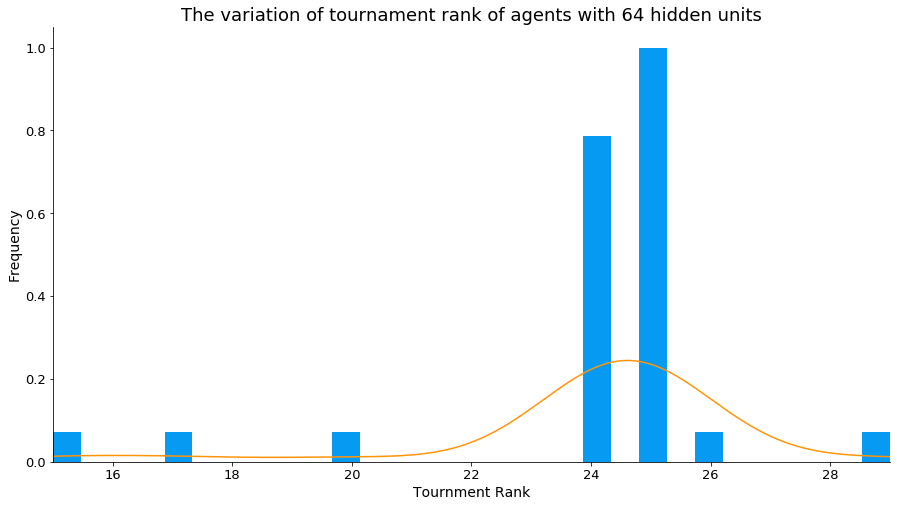

In [114]:
plot_histogram(agents_64u_1lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 64 hidden units and 1 lookback")

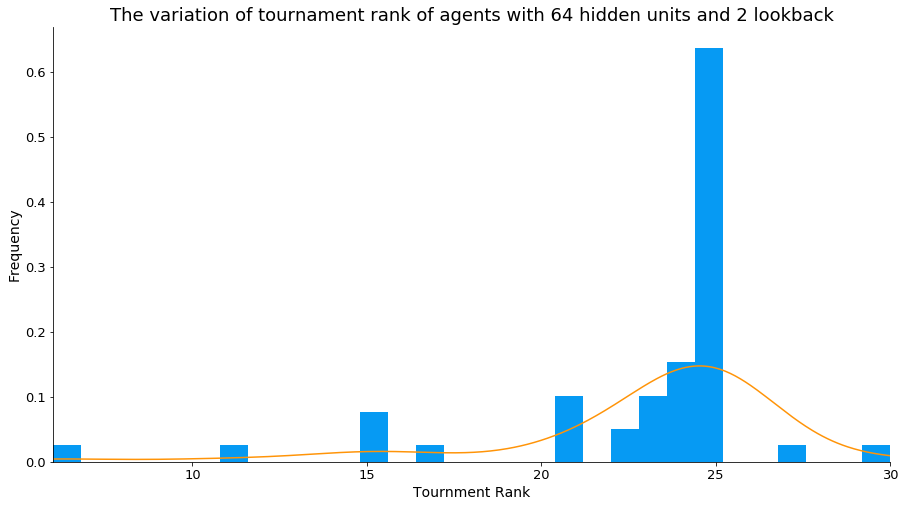

In [115]:
plot_histogram(agents_64u_2lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 64 hidden units and 2 lookback")

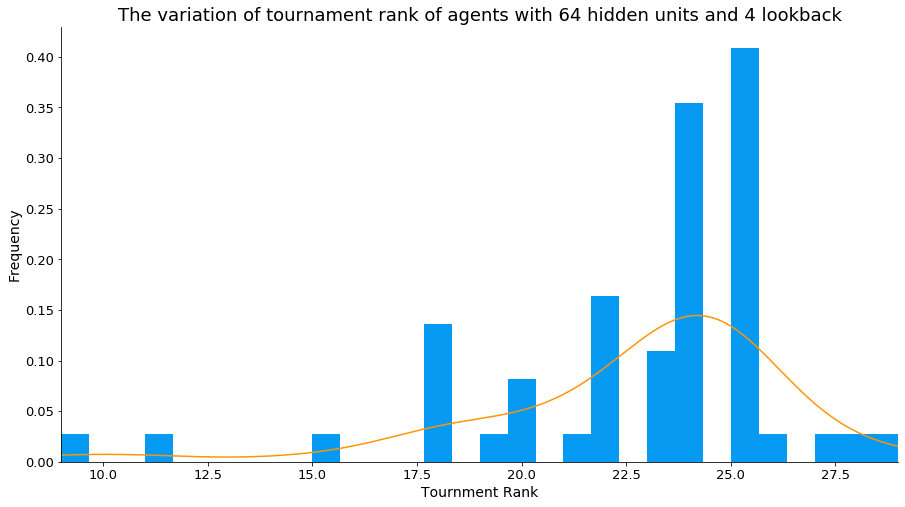

In [116]:
plot_histogram(agents_64u_4lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 64 hidden units and 4 lookback")

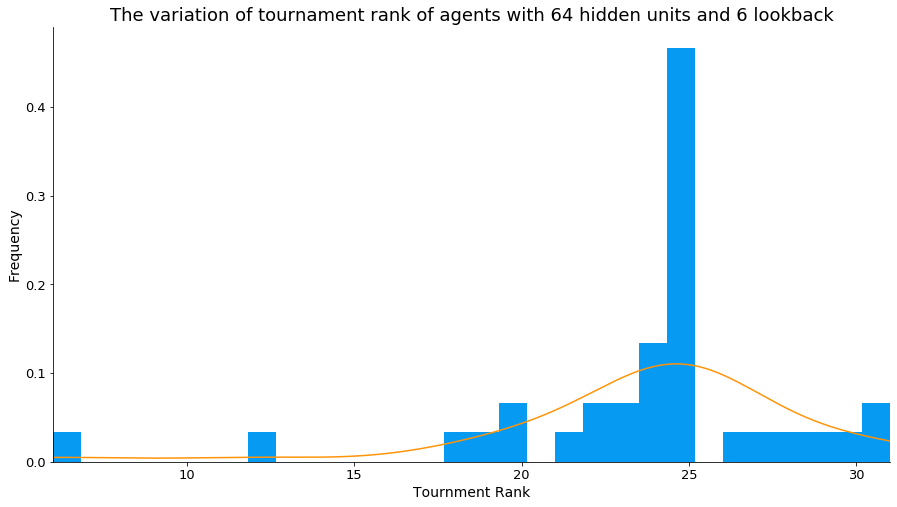

In [117]:
plot_histogram(agents_64u_6lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 64 hidden units and 6 lookback")

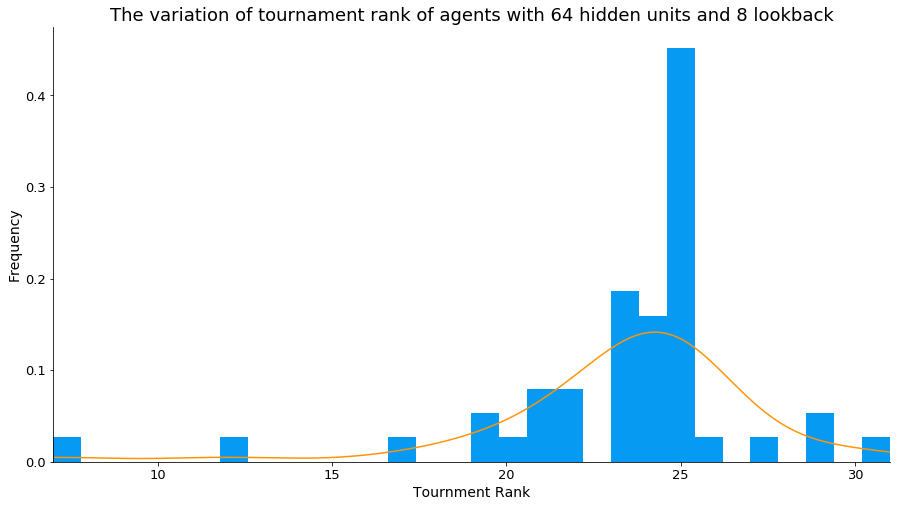

In [118]:
plot_histogram(agents_64u_8lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 64 hidden units and 8 lookback")

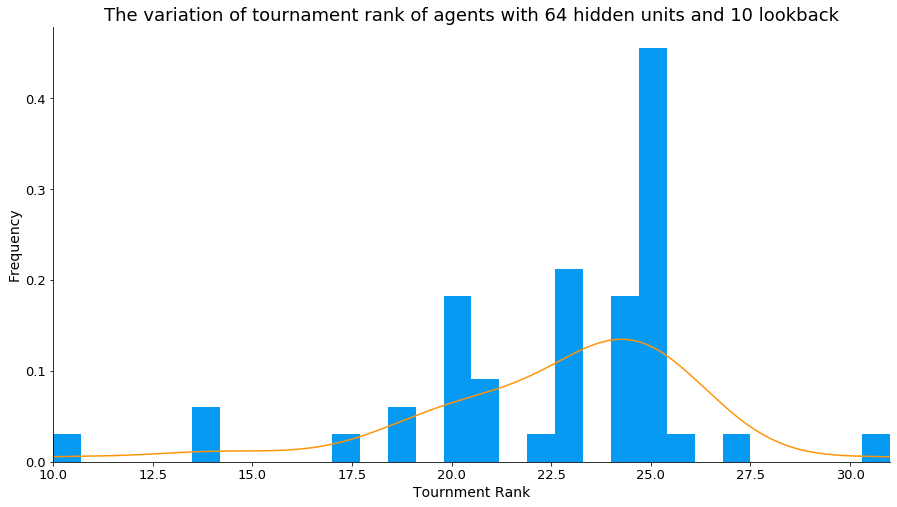

In [119]:
plot_histogram(agents_64u_10lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 64 hidden units and 10 lookback")

In [120]:
agents_128u = df[df["n1"] == 128]

In [121]:
agents_128u_1lb = agents_128u[agents_128u["lookback"] == 1]
agents_128u_2lb = agents_128u[agents_128u["lookback"] == 2]
agents_128u_4lb = agents_128u[agents_128u["lookback"] == 4]
agents_128u_6lb = agents_128u[agents_128u["lookback"] == 6]
agents_128u_8lb = agents_128u[agents_128u["lookback"] == 8]
agents_128u_10lb = agents_128u[agents_128u["lookback"] == 10]

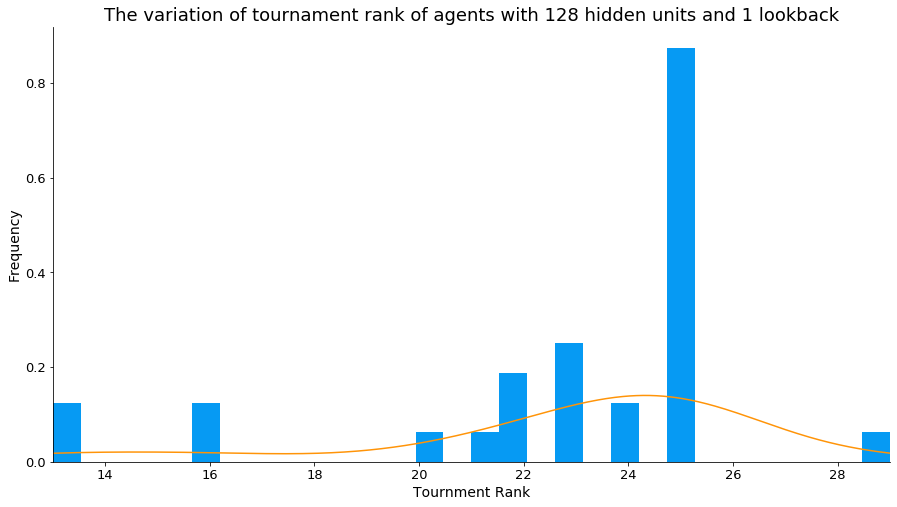

In [122]:
plot_histogram(agents_128u_1lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 128 hidden units and 1 lookback")

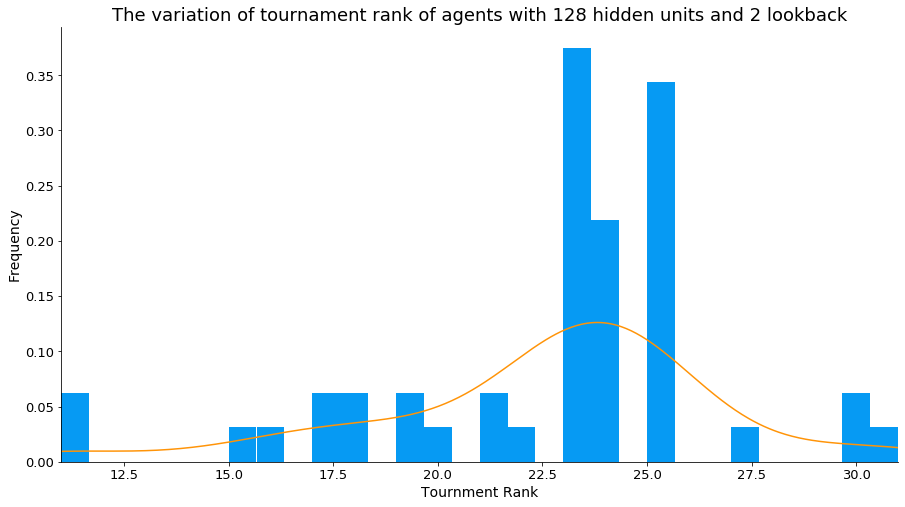

In [123]:
plot_histogram(agents_128u_2lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 128 hidden units and 2 lookback")

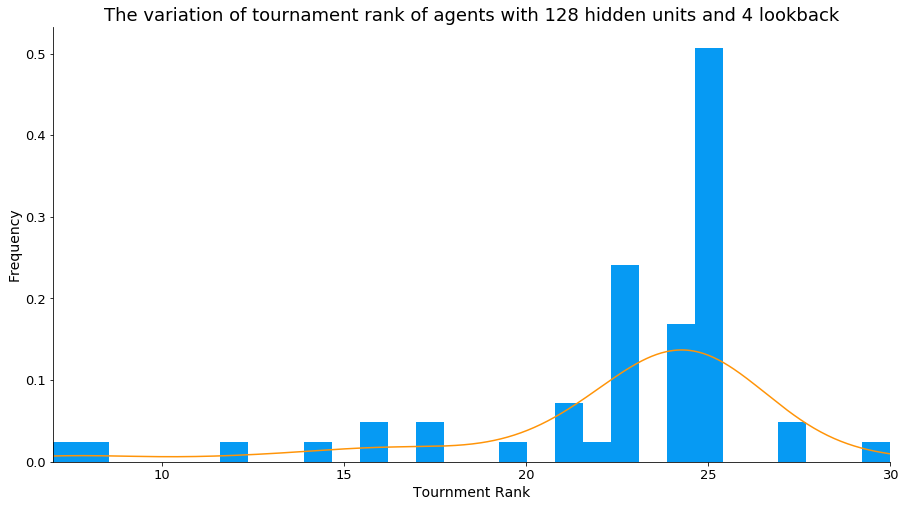

In [124]:
plot_histogram(agents_128u_4lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 128 hidden units and 4 lookback")

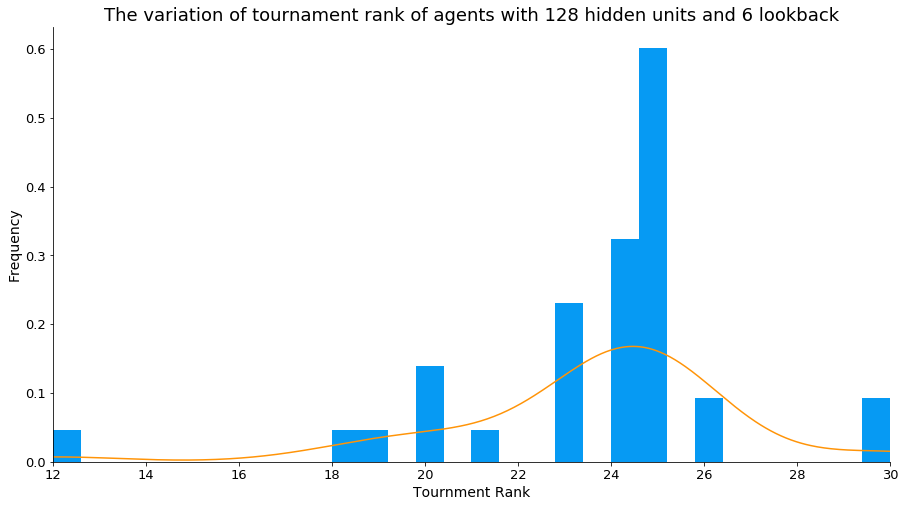

In [125]:
plot_histogram(agents_128u_6lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 128 hidden units and 6 lookback")

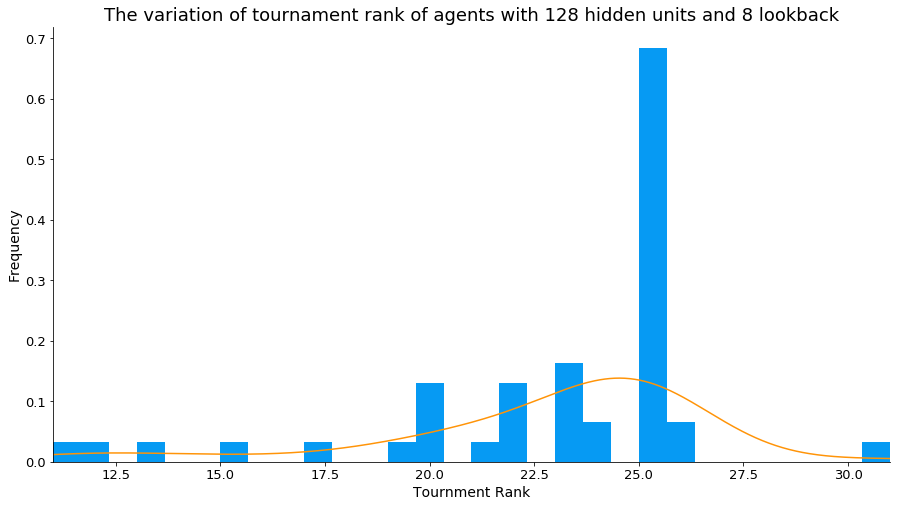

In [126]:
plot_histogram(agents_128u_8lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 128 hidden units and 8 lookback")

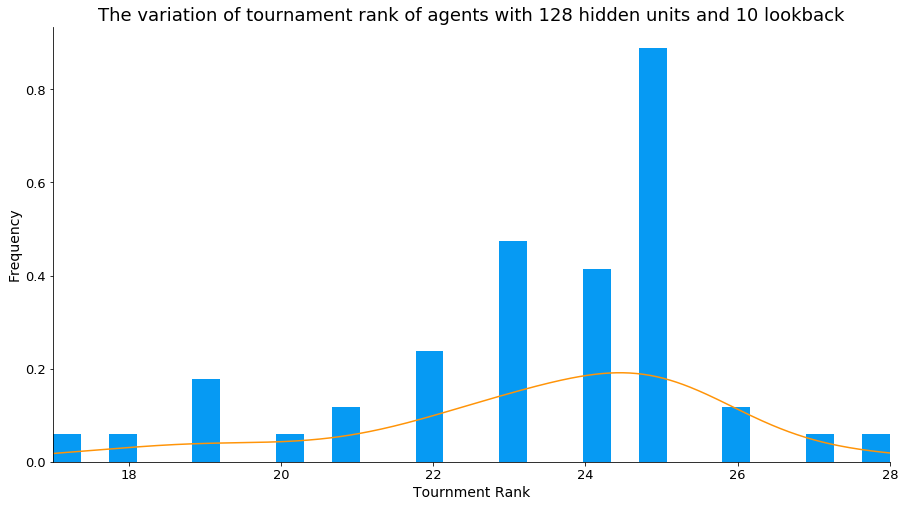

In [127]:
plot_histogram(agents_128u_10lb["tn_rank"], 30, "Tournment Rank", "Frequency", "The variation of tournament rank of agents with 128 hidden units and 10 lookback")

It looks like agents with a lookback of 2 with 128 hidden units performs well. Lets see the average rank.

In [128]:
print(agents_128u_2lb["tn_rank"].sum() / len(agents_128u_2lb))

22.541666666666668


In [129]:
len(agents_128u_2lb)

48